<a href="https://colab.research.google.com/github/arpitsolanki/FPLBot/blob/main/Fantasy_League.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [316]:
import os
import pandas as pd
import requests
import json
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgboost
import datetime

from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.preprocessing import LabelEncoder#Label Encoder
from sklearn.preprocessing import OneHotEncoder#One Hot Encoder
from sklearn.metrics import confusion_matrix#Confusion Matrix
from sklearn.metrics import roc_curve#RoC Curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve#Metrics Functions


In [317]:
#Define GW for predictions
GW=17

#Fantasy API Calls to pull historic player stats
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(url)
response = json.loads(response.content)

#Fixtures for upcoming game weeks
fix_url = 'https://fantasy.premierleague.com/api/fixtures?event='+str(GW)
fix_response = requests.get(fix_url)
fix_response = json.loads(fix_response.content)

In [318]:
def get(url):
    response = requests.get(url)
    return json.loads(response.content)
                      

In [319]:
players = response['elements']
teams = response['teams']
events = response['events']
#fixtures = fix_response['fixtures']

players_df = pd.DataFrame(players)
teams_df = pd.DataFrame(teams)
events_df = pd.DataFrame(events)
fixtures_df=pd.DataFrame(fix_response)
fixtures_df


,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2128450,17,False,False,163,2021-01-01T17:30:00Z,0,False,True,19,0.0,7,0.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,3,59060
1,2128451,17,False,False,164,2021-01-01T20:00:00Z,0,False,False,2,NaN,13,NaN,[],3,4,59061
2,2128454,17,False,False,167,2021-01-02T12:30:00Z,0,False,False,10,NaN,17,NaN,[],2,4,59064
3,2128449,17,False,False,162,2021-01-02T15:00:00Z,0,False,False,15,NaN,6,NaN,[],2,3,59059
4,2128446,17,False,False,159,2021-01-02T17:30:00Z,0,False,False,20,NaN,3,NaN,[],3,2,59056
5,2128455,17,False,False,168,2021-01-02T20:00:00Z,0,False,False,1,NaN,18,NaN,[],3,2,59065
6,2128447,17,False,False,160,2021-01-03T12:00:00Z,0,False,False,8,NaN,4,NaN,[],2,2,59057
7,2128452,17,False,False,165,2021-01-03T14:15:00Z,0,False,False,9,NaN,14,NaN,[],4,3,59062
8,2128448,17,False,False,161,2021-01-03T16:30:00Z,0,False,False,12,NaN,5,NaN,[],4,4,59058
9,2128453,17,False,False,166,2021-01-04T20:00:00Z,0,False,False,11,NaN,16,NaN,[],4,3,59063


In [320]:
#events_df


In [321]:
#Dataset from Fivethirtyeight providing projected scores for the upcoming game week
spi_data = pd.read_csv('https://projects.fivethirtyeight.com/soccer-api/club/spi_matches_latest.csv')
spi_data=spi_data.loc[(spi_data['season']==2020) & (spi_data['league']=='Barclays Premier League')]
#spi_data

#Team mapping file
team_mapping_spi=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/team_mapping.csv')
#team_mapping_spi

#Add team_ids to the 538 dataset to make it compatible with FPL API datasets
spi_data_name=pd.merge(left=spi_data,right=team_mapping_spi,how='inner',left_on='team1',right_on='team')
spi_data_name=spi_data_name.rename(columns={"id": "team1_id"})

spi_data_name=pd.merge(left=spi_data_name,right=team_mapping_spi,how='inner',left_on='team2',right_on='team')
spi_data_name=spi_data_name.rename(columns={"id": "team2_id"})
#spi_data_name

In [322]:
players_df

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0.0,0.0,37605,0,0,-2,2,0,3,0.0,0.0,0,Mesut,0.0,1,False,Not included in Arsenal's 25-man Premier Leagu...,2020-10-20T22:30:18.118477Z,68,37605.jpg,0.0,Özil,0.6,False,None,n,1,3,0,3415,0,53017,3,0.0,0.0,Özil,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,616,247,616,247,616,247,616,247,NaN,,NaN,,NaN,
1,0.0,0.0,39476,0,0,-2,2,0,2,0.0,0.0,0,Sokratis,0.0,2,False,Not included in Arsenal's 25-man Premier Leagu...,2020-10-21T10:30:18.546407Z,48,39476.jpg,0.0,Papastathopoulos,0.1,False,None,n,1,3,0,10258,0,18852,0,0.0,0.0,Sokratis,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,574,212,565,212,553,208,577,212,NaN,,NaN,,NaN,
2,75.0,75.0,41270,0,0,-1,1,0,2,0.6,1.0,0,David,0.3,3,False,Illness - 75% chance of playing,2020-12-26T18:00:15.638627Z,54,41270.jpg,1.1,Luiz Moreira Marinho,0.7,False,None,d,1,3,9,39118,4,89901,30,0.1,1.7,David Luiz,479,0,0,0,9,0,0,0,0,0,0,0,70,99.4,25.8,40.0,16.5,260,100,296,93,259,79,295,97,NaN,,4.0,,NaN,
3,100.0,100.0,54694,0,0,-6,6,1,3,2.6,3.1,0,Pierre-Emerick,2.1,4,False,,2020-12-19T20:30:20.434896Z,114,54694.jpg,3.6,Aubameyang,7.3,False,None,a,1,3,50,508566,81,3149783,160,0.2,4.4,Aubameyang,1256,3,1,4,16,1,0,0,2,0,0,4,146,191.2,208.8,401.0,80.1,147,54,61,41,27,14,38,24,NaN,,NaN,,1.0,
4,100.0,100.0,58822,0,0,-4,4,0,2,0.6,1.1,0,Cédric,0.1,5,False,,2020-09-23T09:00:14.881983Z,46,58822.jpg,1.0,Soares,0.2,False,None,a,1,3,1,3944,1,34661,3,0.0,0.2,Cédric,5,0,0,0,0,0,0,0,0,0,0,0,3,0.0,0.0,0.0,0.0,561,208,549,208,532,202,564,208,NaN,,NaN,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,NaN,NaN,443296,0,0,0,0,0,3,0.0,0.0,0,Theo,0.0,610,False,,None,45,443296.jpg,0.0,Corbeanu,0.0,False,None,a,20,39,0,110,0,57,0,0.0,0.0,Corbeanu,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,555,217,543,218,526,211,558,217,NaN,,NaN,,NaN,
612,NaN,NaN,232361,0,0,0,0,0,3,0.0,0.0,0,Taylor,0.0,611,False,,None,45,232361.jpg,0.0,Perry,0.0,False,None,a,20,39,0,300,1,127,0,0.0,0.0,Perry,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,550,213,538,214,521,207,553,213,NaN,,NaN,,NaN,
613,NaN,NaN,245923,0,0,0,0,0,3,0.0,0.0,0,Luke,0.0,614,False,,None,45,245923.jpg,0.0,Cundle,0.0,False,None,a,20,39,0,198,0,61,2,0.0,0.0,Cundle,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,553,216,541,217,524,210,556,216,NaN,,NaN,,NaN,
614,NaN,NaN,437688,0,0,0,0,0,2,0.0,0.0,0,Lewis,0.0,615,False,,None,40,437688.jpg,0.0,Richards,0.0,False,None,a,20,39,0,251,3,46,1,0.0,0.0,Richards,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,481,186,463,186,432,170,485,186,NaN,,NaN,,NaN,


In [323]:
players_df_filtered=players_df[['web_name','element_type','now_cost','selected_by_percent','points_per_game','team','total_points','minutes','goals_scored','assists','clean_sheets','goals_conceded','yellow_cards','red_cards','bonus','chance_of_playing_next_round']]
players_df_filtered=players_df_filtered.loc[players_df_filtered['minutes']>300]
players_df_filtered['now_cost_mil']=players_df_filtered['now_cost']/10
players_df_filtered['ppm']=players_df_filtered['total_points']/players_df_filtered['now_cost_mil']
players_df_filtered.sort_values(by='ppm',ascending=False,inplace=True)


In [324]:
#players_df_filtered.sort_values(by='total_points',ascending=False)


In [325]:
teams_df_filtered=teams_df[['id','name','short_name','played','points','position','win','draw','loss']]
teams_df_filtered_join=teams_df[['id','name']]


In [326]:
fixtures_df_name=pd.merge(left=fixtures_df,right=teams_df_filtered_join,left_on='team_a',right_on='id',how='left')
fixtures_df_name=fixtures_df_name.rename(columns={"name": "away_team"})
fixtures_df_name=pd.merge(left=fixtures_df_name,right=teams_df_filtered_join,left_on='team_h',right_on='id',how='left')
fixtures_df_name=fixtures_df_name.rename(columns={"name": "home_team"})
fixtures_df_name

,code,event,finished,finished_provisional,id_x,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,id_y,away_team,id,home_team
0,2128450,17,False,False,163,2021-01-01T17:30:00Z,0,False,True,19,0.0,7,0.0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,3,59060,19,West Ham,7,Everton
1,2128451,17,False,False,164,2021-01-01T20:00:00Z,0,False,False,2,NaN,13,NaN,[],3,4,59061,2,Aston Villa,13,Man Utd
2,2128454,17,False,False,167,2021-01-02T12:30:00Z,0,False,False,10,NaN,17,NaN,[],2,4,59064,10,Leeds,17,Spurs
3,2128449,17,False,False,162,2021-01-02T15:00:00Z,0,False,False,15,NaN,6,NaN,[],2,3,59059,15,Sheffield Utd,6,Crystal Palace
4,2128446,17,False,False,159,2021-01-02T17:30:00Z,0,False,False,20,NaN,3,NaN,[],3,2,59056,20,Wolves,3,Brighton
5,2128455,17,False,False,168,2021-01-02T20:00:00Z,0,False,False,1,NaN,18,NaN,[],3,2,59065,1,Arsenal,18,West Brom
6,2128447,17,False,False,160,2021-01-03T12:00:00Z,0,False,False,8,NaN,4,NaN,[],2,2,59057,8,Fulham,4,Burnley
7,2128452,17,False,False,165,2021-01-03T14:15:00Z,0,False,False,9,NaN,14,NaN,[],4,3,59062,9,Leicester,14,Newcastle
8,2128448,17,False,False,161,2021-01-03T16:30:00Z,0,False,False,12,NaN,5,NaN,[],4,4,59058,12,Man City,5,Chelsea
9,2128453,17,False,False,166,2021-01-04T20:00:00Z,0,False,False,11,NaN,16,NaN,[],4,3,59063,11,Liverpool,16,Southampton


In [327]:
df_l=[]
for i in range(GW):
  fix_url = 'https://fantasy.premierleague.com/api/fixtures?event='+str(i+1)
  fix_response = requests.get(fix_url)
  fix_response = json.loads(fix_response.content)
  fixtures_df=pd.DataFrame(fix_response)
  fixtures_df['gw']=i+1
  df_l.append(fixtures_df)
#  print(fix_url)

fixtures_df = pd.concat(df_l, axis=0, ignore_index=True)
fixtures_df_map=fixtures_df[['gw','kickoff_time']].copy()

fixtures_df_map['date']=pd.to_datetime(fixtures_df_map['kickoff_time'], errors='coerce').dt.date

del fixtures_df_map['kickoff_time']
fixtures_df_map=fixtures_df_map.drop_duplicates()
#fixtures_df_map

In [328]:
fixtures_df_name_cur_gw=fixtures_df_name[['home_team','away_team','id','id_y']]
fixtures_df_name_cur_gw.columns=['home_team','away_team','home_id','away_id']



In [329]:
spi_data_name_fil=spi_data_name[['team1','team2','team1_id','team2_id','proj_score1','proj_score2']]
spi_data_name_fil.columns=['team1','team2','home_id','away_id','proj_score1','proj_score2']

spi_gw_scores=pd.merge(left=fixtures_df_name_cur_gw,right=spi_data_name_fil,left_on=['home_id','away_id'],right_on=['home_id','away_id'],how='inner')


In [330]:
players_df_filtered_teams=pd.merge(left=players_df_filtered,right=teams_df_filtered_join,how='inner',left_on='team',right_on='id')
#players_df_filtered_teams

In [331]:
#Read historical fixtures data

team_list=['understat_Arsenal.csv','understat_Aston_Villa.csv','understat_Brighton.csv','understat_Burnley.csv','understat_Chelsea.csv','understat_Crystal_Palace.csv','understat_Everton.csv','understat_Fulham.csv','understat_Leeds.csv','understat_Leicester.csv','understat_Liverpool.csv','understat_Manchester_City.csv','understat_Manchester_United.csv','understat_Newcastle_United.csv','understat_Sheffield_United.csv','understat_Southampton.csv','understat_Tottenham.csv','understat_West_Bromwich_Albion.csv','understat_West_Ham.csv','understat_Wolverhampton_Wanderers.csv']
static='https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/understat/'
df_l=[]

for i in range(20):
  k=static+team_list[i]
  temp=pd.read_csv(k)
 # print(temp.shape[0])
  temp['team']=team_list[i]
  df_l.append(temp)

team_total_data = pd.concat(df_l, axis=0, ignore_index=True)

#team_total_data
#team_mapping_spi
team_total_data_id=pd.merge(left=team_total_data,right=team_mapping_spi,left_on='team',right_on='team_file_name',how='left')
team_total_data_id

team_total_data_id=team_total_data_id[['team_y','id','pts','date','h_a','xG','xGA','deep','deep_allowed','scored','missed']]
# #team_total_data_id
team_total_data_id['date_new']=pd.to_datetime(team_total_data_id['date'], errors='coerce').dt.date

del team_total_data_id['date']
team_total_data_id['cum_pts']=team_total_data_id.groupby(['team_y'])['pts'].cumsum()

#team_total_data_id

team_total_data_id_means = team_total_data_id.join(team_total_data_id.groupby(['id']).expanding().agg({'xG':'mean','xGA': 'mean', 'deep': 'mean', 'deep_allowed': 'mean','scored':'mean','missed':'mean'})
               .reset_index(level=0, drop=True)
               .add_suffix('_roll'))
team_total_data_id_means=team_total_data_id_means.groupby(['id', 'date_new']).last().reset_index()
team_total_data_id_means=team_total_data_id_means[['id','date_new','xG_roll','xGA_roll','deep_roll','deep_allowed_roll','scored_roll','missed_roll']]
team_total_data_id_means
#Create a league standings table
team_total_data_id=pd.merge(left=team_total_data_id,right=fixtures_df_map,left_on='date_new',right_on='date',how='inner')
team_total_data_id.sort_values(by='cum_pts',inplace=True,ascending=False)
team_total_data_id=team_total_data_id[['cum_pts','gw','id','date_new']]
team_total_data_id["rank"] = team_total_data_id.groupby("gw")["cum_pts"].rank("dense", ascending=False)
team_total_data_id.columns=['cum_pts','gw','id','date_new','rank']
#team_total_data_id

team_total_data_id=pd.merge(left=team_total_data_id,right=team_total_data_id_means,left_on=['id','date_new'],right_on=['id','date_new'],how='inner')
del team_total_data_id['date_new']
team_total_data_id['xG_diff']=team_total_data_id['xG_roll']-team_total_data_id['xGA_roll']
team_total_data_id['deep_diff']=team_total_data_id['deep_roll']/(team_total_data_id['deep_roll']+team_total_data_id['deep_allowed_roll'])
team_total_data_id['scored_diff']=team_total_data_id['scored_roll']/(team_total_data_id['scored_roll']+team_total_data_id['missed_roll'])
team_total_data_id=team_total_data_id[['cum_pts','gw','id','rank','xG_diff','deep_diff','scored_diff']]
team_total_data_id
#team_total_data_id.to_csv('team_total_data_id.csv')
#files.download('team_total_data_id.csv')


,cum_pts,gw,id,rank,xG_diff,deep_diff,scored_diff
0,33,16,11,1.0,0.737973,0.780591,0.649123
1,32,15,11,1.0,0.753669,0.781250,0.649123
2,31,14,11,1.0,0.756431,0.765854,0.654545
3,30,16,13,2.0,0.406014,0.616505,0.574074
4,29,16,9,3.0,0.274617,0.520000,0.591837
...,...,...,...,...,...,...,...
305,0,1,18,2.0,-2.602813,0.666667,0.000000
306,0,1,17,2.0,-0.444986,0.642857,0.000000
307,0,3,4,6.0,0.088590,0.428571,0.285714
308,0,1,16,2.0,-0.133020,0.933333,0.000000


In [332]:
#Read Gameweek history

#gw_list=['gw1','gw2','gw3','gw4','gw5','gw6','gw7','gw8','gw9','gw10','gw11','gw12','gw13','gw14','gw15']
gw_list=[]
for i in range(GW-1):
  gw_str='gw'+str(i+1)
  gw_list.append(gw_str)
print(gw_list)

static='https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/'
df_l=[]

for i in range(len(gw_list)):
  k=static+gw_list[i]+'.csv'
  temp=pd.read_csv(k)
  temp['gw']=i+1
  df_l.append(temp)
# print(k)

weekly_data = pd.concat(df_l, axis=0, ignore_index=True)
#weekly_data

weekly_data_team=pd.merge(left=weekly_data,right=teams_df_filtered_join,left_on='opponent_team',right_on='id',how='inner')
weekly_data_team=weekly_data_team.rename(columns={"name_y": "opponent_team_name"})

weekly_data_team=pd.merge(left=weekly_data_team,right=teams_df_filtered_join,left_on='team',right_on='name',how='inner')
weekly_data_team=weekly_data_team.rename(columns={"name_x": "player_name",'id_y':'team_id'})
#weekly_data_team


['gw1', 'gw2', 'gw3', 'gw4', 'gw5', 'gw6', 'gw7', 'gw8', 'gw9', 'gw10', 'gw11', 'gw12', 'gw13', 'gw14', 'gw15', 'gw16']


In [333]:
weekly_data_team.gw.max()

16

In [334]:
#weekly_data_team.iloc[0,33]
#Add the home and away team columns
weekly_data_team['home_team'] = weekly_data_team['team_id']
weekly_data_team['away_team'] = weekly_data_team['team_id']

weekly_data_team.loc[weekly_data_team['was_home'] == True, 'home_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == True, 'team_id']
weekly_data_team.loc[weekly_data_team['was_home'] == True, 'away_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == True, 'opponent_team']

weekly_data_team.loc[weekly_data_team['was_home'] == False, 'home_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == False, 'opponent_team']
weekly_data_team.loc[weekly_data_team['was_home'] == False, 'away_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == False, 'team_id']
#weekly_data_team

weekly_data_team_spi=pd.merge(left=weekly_data_team,right=spi_data_name_fil,left_on=['home_team','away_team'],right_on=['home_id','away_id'],how='inner')
weekly_data_team_spi

#Weekly data remove players who haven't started yet
zero_min=weekly_data_team_spi.groupby(['player_name',]).agg({'minutes':'sum'}).reset_index()
zero_min=zero_min.loc[zero_min['minutes']==0]
#zero_min
#weekly_data_team_spi.player_name.isin(zero_min['player_name']).sum()

weekly_data_team_spi_zero=weekly_data_team_spi[~(weekly_data_team_spi.player_name.isin(zero_min['player_name']))]
# weekly_data_team_spi_zero['team_id']=0
# weekly_data_team_spi_zero.loc[:,'team_id']=weekly_data_team_spi_zero.loc[weekly_data_team_spi_zero['was_home']=True,'home_team']
#weekly_data_team_spi_zero


In [335]:
#Most points in a gameweek
gp=weekly_data.groupby(['name','gw']).agg({'total_points':'sum'}).reset_index()
gp.sort_values(by='total_points',ascending=False)


,name,gw,total_points
3344,Heung-Min Son,2,24
3563,Jack Grealish,4,24
3237,Harry Kane,2,21
7464,Riyad Mahrez,10,21
6449,Mohamed Salah,1,20
...,...,...,...
99,Aboubakar Kamara,6,-2
5567,Luke Shaw,4,-2
2588,Erik Pieters,2,-2
504,Andreas Christensen,2,-3


In [336]:
#Distribution of points scored by players
gp=weekly_data_team_spi_zero.groupby(['total_points']).size().reset_index(name='counts')
#gp.sort_values(by='counts',ascending=False)

fig=px.bar(gp,x='total_points',y='counts',title='Distribution of points scored in gameweek by players')
fig.show()


In [337]:
#Points Distribution by Position
weekly_data_team_spi_zero['point_flag']=0

weekly_data_team_spi_zero.loc[weekly_data_team_spi_zero['total_points']>2,'point_flag']=1
#weekly_data_team_spi_zero

gp=weekly_data_team_spi_zero.groupby(['position','point_flag']).size().reset_index(name='counts')
gp

fig = make_subplots(rows=1, cols=4,specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'},{'type':'domain'}]],subplot_titles=("GK","DEF","MID","FWD"))

fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='GK','point_flag'], values=gp.loc[gp['position']=='GK','counts'], name="GK"),1, 1)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='DEF','point_flag'], values=gp.loc[gp['position']=='DEF','counts'], name="DEF"),1, 2)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='MID','point_flag'], values=gp.loc[gp['position']=='MID','counts'], name="MID"),1, 3)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='FWD','point_flag'], values=gp.loc[gp['position']=='FWD','counts'], name="FW"),1, 4)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Points Distribution by Position")

fig.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [338]:
#weekly_data_team_spi_zero


In [339]:
player_summary=weekly_data_team_spi_zero[['player_name','round','team_id','total_points']]
team_gp=player_summary.groupby(['team_id','round']).agg({'total_points':'sum'}).reset_index()
team_gp.columns=['team_id','round','team_total_points']
team_gp

team_gp['team_total_points_cumsum'] = team_gp.groupby(['team_id'])['team_total_points'].cumsum()
team_gp
del team_gp['team_total_points']
# team_player_gp=player_summary.groupby(['team_id','player_name','round']).agg({'total_points':'sum'}).reset_index()
# team_player_gp.columns=['team_id','player_name','round','team_total_points']
# team_player_gp

# from google.colab import files

# team_player_gp.to_csv('team_player_gp.csv')
# files.download('team_player_gp.csv')


In [340]:
k=weekly_data_subset.loc[weekly_data_subset['gw']==16]
k.team.unique()

array(['Brighton', 'West Ham', 'Sheffield Utd', 'Man Utd', 'Wolves',
       'Liverpool', 'Aston Villa', 'West Brom', 'Arsenal', 'Southampton',
       'Newcastle', 'Chelsea', 'Crystal Palace', 'Burnley', 'Leicester',
       'Leeds'], dtype=object)

In [341]:
#Feature Engineering
weekly_data_subset=weekly_data_team_spi_zero[['player_name','gw','position','team','round','id_x','team_id','xP','assists','bonus','clean_sheets','goals_scored','goals_conceded','minutes','creativity','ict_index','influence','selected','threat','yellow_cards','red_cards','was_home','home_team','away_team','proj_score1','proj_score2','total_points','point_flag']]
weekly_data_subset=weekly_data_subset.rename(columns={"id_x": "opponent_id"})

#Weekly Cumulative sums for last four weeks
weekly_data_subset.sort_values(by=['player_name','gw'],ascending=True,inplace=True)
gp_cols=weekly_data_subset[['player_name','gw','red_cards','yellow_cards','xP','total_points','bonus','clean_sheets','assists','minutes','influence','creativity','threat','ict_index']]
#gp_cols=gp_cols.loc[gp_cols.gw>=GW-4]
gp_cumsum=gp_cols.groupby(['player_name','gw']).sum().groupby('player_name').cumsum().reset_index()

#Season rolling numbers

#Weekly Mean Sums 
weekly_rolling_means = weekly_data_subset.join(weekly_data_subset.groupby(['player_name']).expanding().agg({'minutes':'mean','influence': 'mean', 'creativity': 'mean', 'threat': 'mean','ict_index':'mean','selected':'mean','total_points':'mean'})
               .reset_index(level=0, drop=True)
               .add_suffix('_roll'))
weekly_rolling_means=weekly_rolling_means.groupby(['round', 'player_name']).last().reset_index()
weekly_rolling_means=weekly_rolling_means[['player_name','gw','influence_roll', 'creativity_roll', 'threat_roll','ict_index_roll','minutes_roll','selected_roll','total_points_roll']]



weekly_data_subset_new=weekly_data_subset[['player_name','gw','position','team','round','team_id','opponent_id','was_home','home_team','away_team','proj_score1','proj_score2','point_flag']].copy()

weekly_data_subset_new['join_key']=0
gw=weekly_data_subset_new['gw']
weekly_data_subset_new.loc[:,'join_key']=gw-1

#Merge cumulative sums
weekly_data_subset_new_agg=pd.merge(left=weekly_data_subset_new,right=weekly_rolling_means,left_on=['player_name','join_key'],right_on=['player_name','gw'],how='inner')

#Merge cumulative means
weekly_data_subset_new_agg=pd.merge(left=weekly_data_subset_new_agg,right=gp_cumsum,left_on=['player_name','join_key'],right_on=['player_name','gw'],how='inner')

#Merge team total ranking stats with home team
weekly_data_subset_new_agg_home=pd.merge(left=weekly_data_subset_new_agg,right=team_total_data_id,left_on=['team_id','join_key'],right_on=['id','gw'])
weekly_data_subset_new_agg_home=weekly_data_subset_new_agg_home.rename(columns={"rank": "team_rank",'cum_pts':'team_pts','xG_diff':'xG_diff_team','scored_diff':'scored_diff_team','deep_diff':'deep_diff_team'})

#Merge team total ranking stats with away team
weekly_data_subset_new_agg_pts=pd.merge(left=weekly_data_subset_new_agg_home,right=team_total_data_id,left_on=['opponent_id','join_key'],right_on=['id','gw'])
weekly_data_subset_new_agg_pts=weekly_data_subset_new_agg_pts.rename(columns={"rank": "opponent_rank",'cum_pts':'opponent_points','xG_diff':'xG_diff_opponent','scored_diff':'scored_diff_opponent','deep_diff':'deep_diff_opponent'})

#Calculate rank and projected score differences for the upcoming fixture
weekly_data_subset_new_agg_pts['rank_diff']=weekly_data_subset_new_agg_pts['team_rank']-weekly_data_subset_new_agg_pts['opponent_rank']
weekly_data_subset_new_agg_pts['proj_score_diff']=weekly_data_subset_new_agg_pts['proj_score1']-weekly_data_subset_new_agg_pts['proj_score2']

#Merge team total ranking stats with away team
weekly_data_subset_new_agg_pts_team=pd.merge(left=weekly_data_subset_new_agg_pts,right=team_gp,left_on=['team_id','join_key'],right_on=['team_id','round'],how='inner')

weekly_data_subset_new_agg_pts_team['percent_team_points']=weekly_data_subset_new_agg_pts_team['total_points']/weekly_data_subset_new_agg_pts_team['team_total_points_cumsum']

# ##del weekly_data_subset_new_agg_pts['gw']
del weekly_data_subset_new_agg_pts_team['gw_y']
del weekly_data_subset_new_agg_pts_team['gw_x']
del weekly_data_subset_new_agg_pts_team['id_x']
del weekly_data_subset_new_agg_pts_team['id_y']
del weekly_data_subset_new_agg_pts_team['join_key']
del weekly_data_subset_new_agg_pts_team['team_id']
del weekly_data_subset_new_agg_pts_team['opponent_id']

weekly_data_subset_new_agg_pts_team

#weekly_data_subset_new_agg_pts_team.to_csv('weekly_data_subset_new_agg_pts_team.csv')
#files.download('weekly_data_subset_new_agg_pts_team.csv')

,player_name,position,team,round_x,was_home,home_team,away_team,proj_score1,proj_score2,point_flag,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,total_points_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,round_y,team_total_points_cumsum,percent_team_points
0,Aaron Connolly,FWD,Brighton,2,False,14,3,1.28,1.13,1,1.2,0.30,32.0,3.40,45.0,32205.0,1.0,0,0,0.5,1,0,0,0,45,1.2,0.3,32.0,3.4,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
1,Adam Lallana,MID,Brighton,2,False,14,3,1.28,1.13,0,6.8,27.20,2.0,3.60,44.0,78657.0,1.0,0,0,1.2,1,0,0,0,44,6.8,27.2,2.0,3.6,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
2,Adam Webster,DEF,Brighton,2,False,14,3,1.28,1.13,1,14.8,11.80,1.0,2.80,90.0,187445.0,1.0,0,0,0.6,1,0,0,0,90,14.8,11.8,1.0,2.8,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
3,Alexis Mac Allister,MID,Brighton,2,False,14,3,1.28,1.13,0,0.0,0.00,0.0,0.00,0.0,3939.0,0.0,0,0,0.8,0,0,0,0,0,0.0,0.0,0.0,0.0,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.000000
4,Alireza Jahanbakhsh,MID,Brighton,2,False,14,3,1.28,1.13,0,4.4,0.70,0.0,0.50,11.0,3104.0,1.0,0,0,0.8,1,0,0,0,11,4.4,0.7,0.0,0.5,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6268,Patrick Bamford,FWD,Leeds,3,False,15,10,1.40,1.05,1,45.2,6.20,24.0,7.55,65.0,489813.0,10.5,0,0,10.6,21,3,0,2,130,90.4,12.4,48.0,15.1,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.228261
6269,Robin Koch,DEF,Leeds,3,False,15,10,1.40,1.05,1,17.9,0.25,19.5,3.80,90.0,36835.0,0.5,0,0,0.6,1,0,0,0,180,35.8,0.5,39.0,7.6,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.010870
6270,Rodrigo Moreno,FWD,Leeds,3,False,15,10,1.40,1.05,0,0.0,0.50,2.0,0.25,36.5,467745.0,1.0,0,0,1.3,2,0,0,0,73,0.0,1.0,4.0,0.5,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.021739
6271,Stuart Dallas,DEF,Leeds,3,False,15,10,1.40,1.05,1,22.2,2.50,3.0,2.80,90.0,307651.0,2.0,0,0,2.1,4,0,0,1,180,44.4,5.0,6.0,5.6,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.043478


In [342]:
# weekly_data_subset=weekly_data_subset.sort_values(by=['player_name','gw']).reset_index(drop=True)
# #weekly_data_subset

# weekly_rolling_means = weekly_data_subset.join(weekly_data_subset.groupby(['player_name']).expanding().agg({'minutes':'mean','influence': 'mean', 'creativity': 'mean', 'threat': 'mean','ict_index':'mean'})
#                .reset_index(level=0, drop=True)
#                .add_suffix('_roll'))

# weekly_rolling_means=weekly_rolling_means.groupby(['round', 'player_name']).last().reset_index()
# weekly_rolling_means=weekly_rolling_means[['player_name','gw','influence_roll', 'creativity_roll', 'threat_roll','ict_index_roll','minutes_roll']]
# weekly_rolling_means
# # k.to_csv('k.csv')
# # files.download('k.csv')

gp_cumsum

,player_name,gw,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index
0,Aaron Connolly,1,0,0,0.5,1,0,0,0,45,1.2,0.3,32.0,3.4
1,Aaron Connolly,2,0,0,4.5,9,2,1,0,134,36.0,11.6,55.0,10.3
2,Aaron Connolly,3,0,0,7.2,11,2,1,0,207,36.0,23.7,63.0,12.2
3,Aaron Connolly,4,0,0,9.9,13,2,1,0,272,39.0,24.0,67.0,12.9
4,Aaron Connolly,5,0,0,12.9,17,2,1,1,284,56.2,34.3,69.0,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,Çaglar Söyüncü,12,0,1,12.0,8,0,1,0,360,83.4,24.6,44.0,15.2
6894,Çaglar Söyüncü,13,0,1,12.0,8,0,1,0,360,83.4,24.6,44.0,15.2
6895,Çaglar Söyüncü,14,0,1,12.0,8,0,1,0,360,83.4,24.6,44.0,15.2
6896,Çaglar Söyüncü,15,0,1,12.0,8,0,1,0,360,83.4,24.6,44.0,15.2


In [343]:
#Handling categorical variable
labelencoder = LabelEncoder()
weekly_data_subset_new_agg_pts_team['position_flag'] = labelencoder.fit_transform(weekly_data_subset_new_agg_pts_team['position'])

cols = pd.get_dummies(weekly_data_subset_new_agg_pts_team['position_flag'])
cols.columns = ['pos_0','pos_1','pos_2','pos_3']
weekly_data_subset_new_agg_pts_team1 = pd.concat([weekly_data_subset_new_agg_pts_team, cols], axis=1)

#weekly_data_subset_new_agg_pts_team1

In [344]:
weekly_data_subset_new_agg_pts_team2=weekly_data_subset_new_agg_pts_team1.copy()
X=weekly_data_subset_new_agg_pts_team1.copy()
#Y=weekly_data_subset_new_agg['point_flag']
del X['player_name']
del X['position']
del X['team']
#del X['total_points']
#X_train,X_test,Y_train,Y_test=train_test_split(X, Y,test_size=0.3,random_state=1)

max_gw=X['round_x'].max()
print(max_gw)
#max_gw=14

X_train=X.loc[X['round_x']<max_gw]
X_test=X.loc[X['round_x']==max_gw]
Y_train=X_train['point_flag']
Y_test=X_test['point_flag']
del X_train['point_flag']
del X_test['point_flag']

del X_train['round_x']
del X_test['round_x']

del X_train['round_y']
del X_test['round_y']



16


In [345]:
#X_test


Model Accuracy
0.7851239669421488


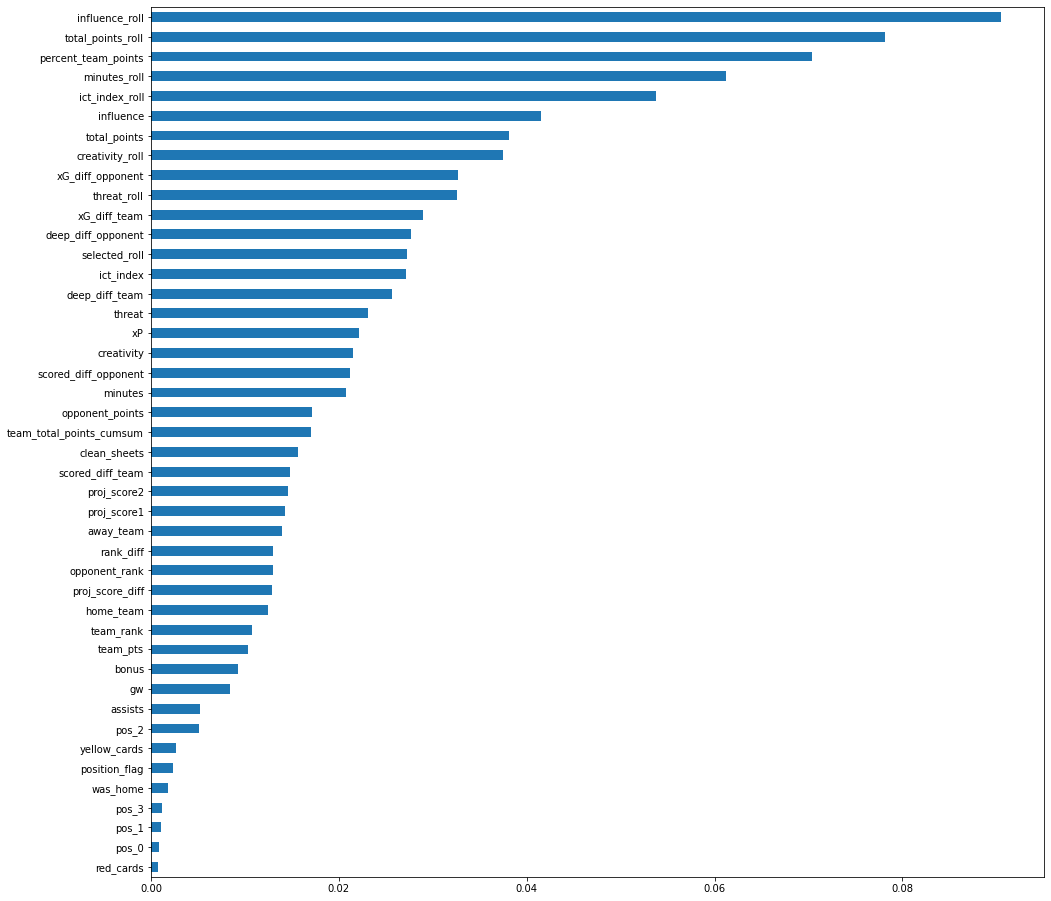

In [346]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model_rf = RandomForestClassifier(n_estimators=100,max_depth=7, random_state=0,min_samples_split=10)
#class_weight='balanced_subsample'
model_rf.fit(X_train,Y_train)#Fitting the model 
#Generating predictions from Random Fores Models
pred_rf=model_rf.predict(X_test)
pred_rf_proba=model_rf.predict_proba(X_test)

feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance

print('Model Accuracy')
print(model_rf.score(X_test,Y_test))

In [347]:
import statistics

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_rf, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % statistics.mean(scores))

Mean ROC AUC: 0.771


0.21980349246940137


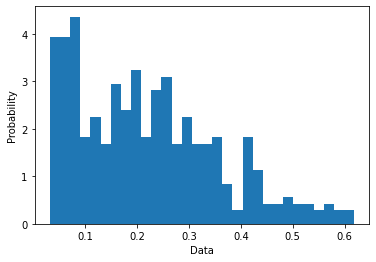

In [348]:
import plotly.express as px
import matplotlib.pyplot as plt

def plot_hist(pred):
  plt.hist(pred[:,1], density=True, bins=30)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')

plot_hist(pred_rf_proba)
print(pred_rf_proba[:,1].mean())

Predicted    0    1  All
Actual                  
0          121  157  278
1           17   68   85
All        138  225  363


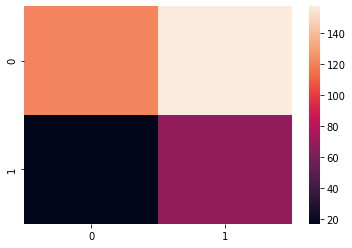

True Positive Rate [0.4352518 0.8      ]


In [349]:
#Confusion Matrix & True Positive Rate
calc_pred=pred_rf_proba[:,1]>0.16
calc_pred=calc_pred.astype(int)

conf_mat = confusion_matrix(Y_test, calc_pred)
df_confusion = pd.crosstab(Y_test, calc_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

#print(conf_mat)

# Visualize it as a heatmap
import seaborn
import matplotlib.pyplot as plt

seaborn.heatmap(conf_mat)
plt.show()

FP = conf_mat.sum(axis=0) - np.diag(conf_mat)  
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
TPR = TP/(TP+FN)

print("True Positive Rate",TPR)

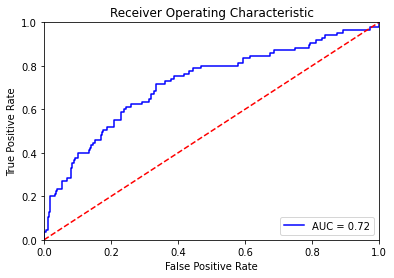

In [350]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


def plot_curve(pred):
  fpr, tpr, threshold = metrics.roc_curve(Y_test, pred[:,1])
  roc_auc = metrics.auc(fpr, tpr)

# method I: plt
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
plot_curve(pred_rf_proba)

In [351]:
# optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), pred_rf_proba)), key=lambda i: i[0], reverse=True)[0][1]
# print(optimal_proba_cutoff)

# roc_predictions=calc_pred=pred_rf_proba[:,1]>0.26
# roc_predictions=roc_predictions.astype(int)

#roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]]

In [352]:
# print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(Y_test, roc_predictions), accuracy_score(Y_test, roc_predictions)))
# print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(Y_test, roc_predictions), precision_score(Y_test, roc_predictions)))
# print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(Y_test, roc_predictions), recall_score(Y_test, roc_predictions)))


 XGBoost

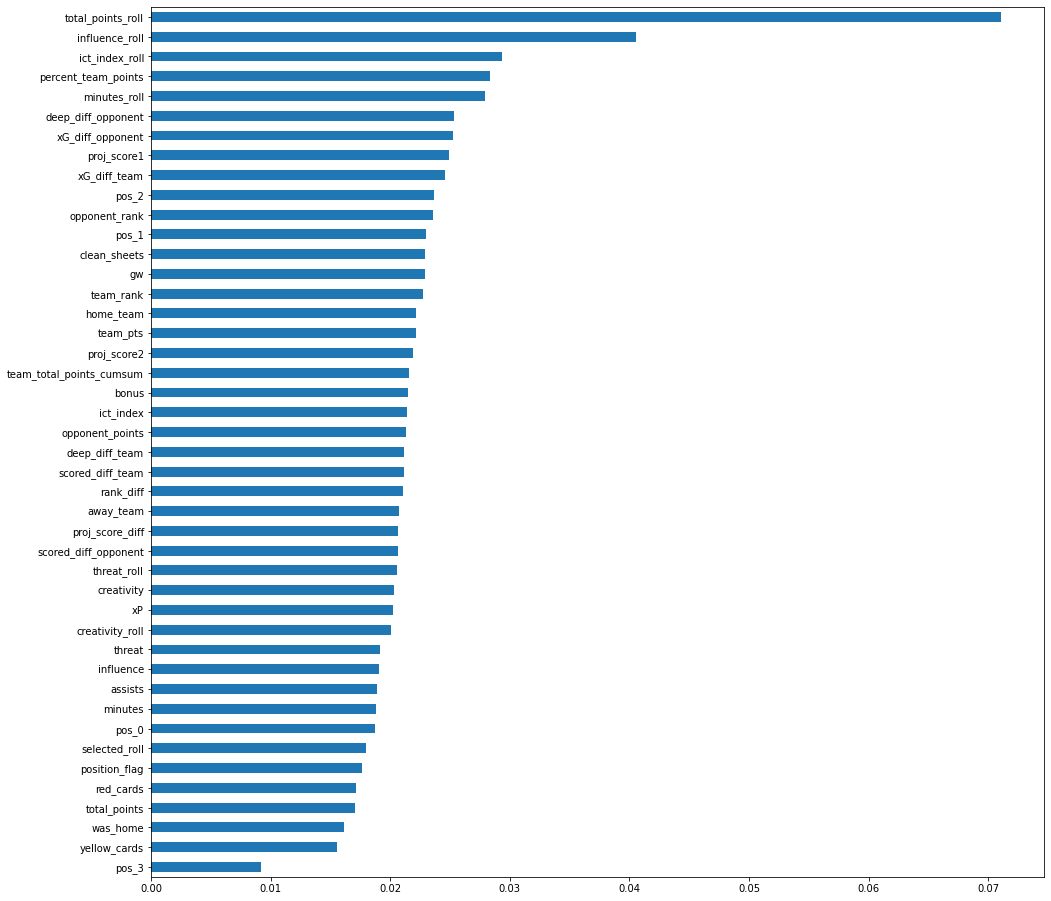

In [353]:
from xgboost import XGBClassifier


model_xg = XGBClassifier(max_depth=7,
   # 'max_leaves' : 2**4,
    alpha=0.1, 
   # 'lambda' : 0.2,
   eta=0.1,
    subsample=0.7,
    min_child_weight =5,
    learning_rate=0.1, #default = 0.3,
    colsample_bytree=0.7,
    eval_metric='auc', 
    objective = 'binary:logistic',
    grow_policy='lossguide',
    n_estimators=100)
model_xg.fit(X_train, Y_train)
pred_xg_proba=model_xg.predict_proba(X_test)

feat_importances = pd.Series(model_xg.feature_importances_, index=X_train.columns)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance



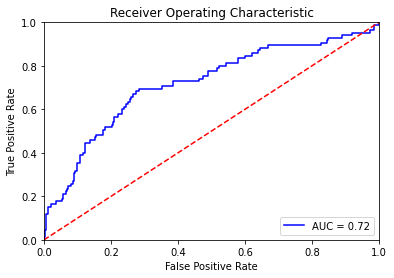

Predicted    0    1  All
Actual                  
0          182   96  278
1           26   59   85
All        208  155  363


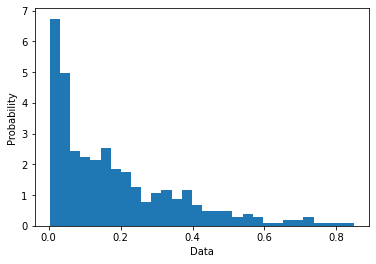

In [354]:
plot_curve(pred_xg_proba)
plot_hist(pred_xg_proba)

calc_pred=pred_xg_proba[:,1]>0.16
calc_pred=calc_pred.astype(int)

conf_mat = confusion_matrix(Y_test, calc_pred)
df_confusion = pd.crosstab(Y_test, calc_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

In [355]:
X_cols=weekly_data_subset_new_agg_pts_team2[['player_name','position','team','total_points','point_flag']].copy()
X_test_pred=pd.merge(X_test, X_cols, left_index=True, right_index=True)
#X_test_pred['predictions']=pred_rf_proba[:,1]
X_test_pred['predictions']=pred_xg_proba[:,1]


In [356]:
X_test_pred.loc[X_test_pred['predictions']>0.5].sort_values(by='predictions',ascending=False).head(20)


,was_home,home_team,away_team,proj_score1,proj_score2,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,total_points_roll,red_cards,yellow_cards,xP,total_points_x,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,team_total_points_cumsum,percent_team_points,position_flag,pos_0,pos_1,pos_2,pos_3,player_name,position,team,total_points_y,point_flag,predictions
1271,True,13,20,1.90,0.84,45.242857,44.900000,32.428571,12.271429,80.214286,2.296631e+06,8.142857,0,3,111.8,114,19,3,7,1123,633.4,628.6,454.0,171.8,27,4.0,0.358513,0.606218,0.566038,21,15,8.0,-0.306933,0.385542,0.428571,-4.0,1.06,616,0.185065,3,0,0,0,1,Bruno Miguel Borges Fernandes,MID,Man Utd,114,1,0.849448
3135,True,18,10,1.29,1.64,30.746667,0.000000,0.000000,3.073333,90.000000,8.956740e+04,3.466667,0,0,44.3,52,7,2,0,1350,461.2,0.0,0.0,46.1,8,14.0,-1.484333,0.278947,0.268293,20,15,9.0,-0.293730,0.518519,0.454545,5.0,-0.35,443,0.117381,2,0,0,1,0,Sam Johnstone,GK,West Brom,52,0,0.795825
6222,False,18,10,1.29,1.64,19.600000,28.553333,16.066667,6.433333,77.266667,1.357141e+05,3.800000,0,0,45.5,57,4,5,4,1159,294.0,428.3,241.0,96.5,20,9.0,-0.293730,0.518519,0.454545,8,15,14.0,-1.484333,0.278947,0.268293,-5.0,-0.35,647,0.088099,3,0,0,0,1,Jack Harrison,MID,Leeds,57,1,0.777839
6221,False,18,10,1.29,1.64,30.733333,0.666667,0.000000,3.146667,90.000000,2.797429e+05,4.133333,0,0,54.4,62,9,5,0,1350,461.0,10.0,0.0,47.2,20,9.0,-0.293730,0.518519,0.454545,8,15,14.0,-1.484333,0.278947,0.268293,-5.0,-0.35,647,0.095827,2,0,0,1,0,Illan Meslier,GK,Leeds,62,1,0.750056
1282,True,13,20,1.90,0.84,27.128571,20.214286,36.428571,8.378571,84.500000,5.290666e+05,5.357143,0,1,71.5,75,4,3,4,1183,379.8,283.0,510.0,117.3,27,4.0,0.358513,0.606218,0.566038,21,15,8.0,-0.306933,0.385542,0.428571,-4.0,1.06,616,0.121753,3,0,0,0,1,Marcus Rashford,MID,Man Utd,75,1,0.735043
5673,False,6,9,1.15,1.65,25.760000,0.000000,0.000000,2.573333,90.000000,8.790293e+05,3.933333,0,0,60.0,59,3,5,0,1350,386.4,0.0,0.0,38.6,28,3.0,0.199594,0.511765,0.595745,18,15,10.0,-0.472420,0.482412,0.404255,-7.0,-0.50,666,0.088589,2,0,0,1,0,Kasper Schmeichel,GK,Leicester,59,0,0.715386
6232,False,18,10,1.29,1.64,14.072727,21.981818,27.909091,6.400000,60.272727,2.761627e+04,2.727273,0,2,26.0,30,1,3,2,663,154.8,241.8,307.0,70.4,20,9.0,-0.293730,0.518519,0.454545,8,15,14.0,-1.484333,0.278947,0.268293,-5.0,-0.35,647,0.046368,3,0,0,0,1,Raphael Dias Belloli,MID,Leeds,30,1,0.712520
6228,False,18,10,1.29,1.64,20.946667,27.786667,12.733333,6.153333,83.600000,4.458127e+05,4.000000,0,4,53.3,60,3,5,4,1254,314.2,416.8,191.0,92.3,20,9.0,-0.293730,0.518519,0.454545,8,15,14.0,-1.484333,0.278947,0.268293,-5.0,-0.35,647,0.092736,3,0,0,0,1,Mateusz Klich,MID,Leeds,60,1,0.700421
6235,False,18,10,1.29,1.64,21.880000,10.360000,15.066667,4.740000,89.333333,4.655991e+05,3.866667,0,3,49.0,58,2,5,1,1340,328.2,155.4,226.0,71.1,20,9.0,-0.293730,0.518519,0.454545,8,15,14.0,-1.484333,0.278947,0.268293,-5.0,-0.35,647,0.089645,0,1,0,0,0,Stuart Dallas,DEF,Leeds,58,1,0.694880
5067,True,4,15,1.33,0.88,26.500000,0.714286,0.000000,2.721429,83.571429,8.244748e+05,4.928571,0,0,55.0,69,14,5,0,1170,371.0,10.0,0.0,38.1,13,12.0,-0.658199,0.369792,0.285714,2,15,15.0,-0.651985,0.420513,0.235294,-3.0,0.45,500,0.138000,2,0,0,1,0,Nick Pope,GK,Burnley,69,1,0.661470


In [357]:
#from google.colab import files

X_test_pred.to_csv('df.csv')
#files.download('df.csv')


In [358]:
#weekly_data_subset['round'].max()


In [359]:
#Prepare dataset for future game week predictions
fixtures_df1=fixtures_df[['event','team_h','team_a']]
max_week=weekly_data_subset['round'].max()
print(max_week)

#UNCOMMENT THIS LATER
#pred_data=weekly_data_subset.loc[weekly_data_subset['round']==max_week]
pred_data=weekly_data_subset
fixtures_df1=fixtures_df1.loc[fixtures_df1['event']==max_week+1]

#fixtures_df1=fixtures_df1.loc[fixtures_df1['event']==max_week]

pred_data=pred_data[['player_name','position','team','team_id','round']].reset_index(drop=True)
pred_data=pred_data.drop_duplicates(subset=['player_name','position','team','team_id'])
pred_data['round']=16
print(pred_data.shape)
pred_data
#fixtures_df

pred_data=pd.merge(left=pred_data,right=fixtures_df1,left_on='team_id',right_on='team_h',how='left')
pred_data=pd.merge(left=pred_data,right=fixtures_df1,left_on='team_id',right_on='team_a',how='left')

pred_data.loc[pred_data['team_h_x'].isna(),'team_h_x']=pred_data.loc[pred_data['team_h_x'].isna(),'team_h_y']
pred_data.loc[pred_data['team_a_x'].isna(),'team_a_x']=pred_data.loc[pred_data['team_a_x'].isna(),'team_a_y']
pred_data=pred_data[['player_name','position','team','team_id','team_h_x','team_a_x','round']]
pred_data=pred_data.rename(columns={"round": "gw","team_h_x": "home_team","team_a_x":"away_team"})

# #weekly_data_subset_new=weekly_data_subset[['player_name','gw','position','team','round','team_id','opponent_id','selected','was_home','home_team','away_team','proj_score1','proj_score2','point_flag']].copy()

# #Home Flag
pred_data['was_home']=0
pred_data.loc[pred_data['home_team']==pred_data['team_id'],'was_home']=1

#TOBECHANGED
pred_data['gw']=GW-1

pred_data['opponent_id']=0

pred_data['opponent_id']=pred_data['home_team']
pred_data.loc[pred_data['was_home']==1,'opponent_id']=pred_data.loc[pred_data['was_home']==1,'away_team']
#pred_data

#Rolling means dataset. Take latest available record for a player to account for empty gameweeks or covid cancellations
weekly_rolling_means_latest_stats=weekly_rolling_means.sort_values(by='gw',ascending=False).groupby('player_name').head(1)
weekly_rolling_means_latest_stats['gw']=max_week

pred_data_roll=pd.merge(left=pred_data,right=weekly_rolling_means_latest_stats,left_on=['player_name','gw'],right_on=['player_name','gw'],how='inner')

# #Merge cumulative means
gp_cumsum_latest_stats=gp_cumsum.sort_values(by='gw',ascending=False).groupby('player_name').head(1)
gp_cumsum_latest_stats['gw']=max_week
pred_data_roll_cum=pd.merge(left=pred_data_roll,right=gp_cumsum_latest_stats,left_on=['player_name','gw'],right_on=['player_name','gw'],how='inner')
#pred_data_roll_cum

# # #Merge team total ranking stats with home team
#Calculate latest availalbe team stats for the team. Useful when teams have blank gameweeks and are not playing in the game
latest_rank=team_total_data_id.sort_values(by='gw',ascending=False).groupby('id').head(1)
latest_rank['gw']=max_week
pred_data_roll_cum_team=pd.merge(left=pred_data_roll_cum,right=latest_rank,left_on=['team_id','gw'],right_on=['id','gw'])
pred_data_roll_cum_team=pred_data_roll_cum_team.rename(columns={"rank": "team_rank",'cum_pts':'team_pts','xG_diff':'xG_diff_team','scored_diff':'scored_diff_team','deep_diff':'deep_diff_team'})

# # #Merge team total ranking stats with away team
pred_data_roll_cum_team=pd.merge(left=pred_data_roll_cum_team,right=latest_rank,left_on=['opponent_id','gw'],right_on=['id','gw'])
pred_data_roll_cum_team=pred_data_roll_cum_team.rename(columns={"rank": "opponent_rank",'cum_pts':'opponent_points','xG_diff':'xG_diff_opponent','scored_diff':'scored_diff_opponent','deep_diff':'deep_diff_opponent'})
pred_data_roll_cum_team

# #Merge team total ranking stats with away team
team_gp_latest=team_gp.sort_values(by='round',ascending=False).groupby('team_id').head(1)
team_gp_latest['round']=max_week
pred_data_roll_cum_team_pts=pd.merge(left=pred_data_roll_cum_team,right=team_gp_latest,left_on=['team_id','gw'],right_on=['team_id','round'],how='inner')
pred_data_roll_cum_team_pts['percent_team_points']=pred_data_roll_cum_team_pts['total_points']/pred_data_roll_cum_team_pts['team_total_points_cumsum']
pred_data_roll_cum_team_pts['gw']=max_week+1

pred_data_roll_cum_team_pts_spi=pd.merge(left=pred_data_roll_cum_team_pts,right=spi_data_name_fil,left_on=['home_team','away_team'],right_on=['home_id','away_id'],how='inner')

# #Calculate rank and projected score differences for the upcoming fixture
pred_data_roll_cum_team_pts_spi['rank_diff']=pred_data_roll_cum_team_pts_spi['team_rank']-pred_data_roll_cum_team_pts_spi['opponent_rank']
pred_data_roll_cum_team_pts_spi['proj_score_diff']=pred_data_roll_cum_team_pts_spi['proj_score1']-pred_data_roll_cum_team_pts_spi['proj_score2']

#pred_data_roll_cum_team_pts_spi

16
(462, 5)


In [360]:
pred_data_roll_cum_team_pts_spi.shape

(462, 51)

In [361]:
# pred_data_roll=pd.merge(left=pred_data,right=weekly_rolling_means_latest_stats,left_on=['player_name','gw'],right_on=['player_name','gw'],how='left')
# pred_data_roll.loc[pred_data_roll.influence_roll.isna()]
team_gp

,team_id,round,team_total_points_cumsum
0,1,1,82
1,1,2,128
2,1,3,151
3,1,4,196
4,1,5,221
...,...,...,...
305,20,12,490
306,20,13,533
307,20,14,554
308,20,15,587


In [362]:
pred_data_roll_cum_team_pts_spi['position_flag'] = labelencoder.fit_transform(pred_data_roll_cum_team_pts_spi['position'])
cols = pd.get_dummies(pred_data_roll_cum_team_pts_spi['position_flag'])
cols.columns = ['pos_0','pos_1','pos_2','pos_3']
pred_data_roll_cum_team_pts_spi1 = pd.concat([pred_data_roll_cum_team_pts_spi, cols], axis=1)
pred_data_roll_cum_team_pts_spi1

pred_data_roll_cum_team_pts_spi1.drop(['player_name','position','team','team1','team2','away_id','home_id','id_x','id_y','opponent_id','team_id','round'],axis=1,inplace=True)

#Reorder columns in the test data to be in the same order as train data
pred_data_roll_cum_team_pts_spi1=pred_data_roll_cum_team_pts_spi1[X_train.columns]
proba_rf=model_rf.predict_proba(pred_data_roll_cum_team_pts_spi1)
proba_xg=model_xg.predict_proba(pred_data_roll_cum_team_pts_spi1)

#pred_data_roll_cum_team_pts_spi['predicted']=proba_rf[:,1]

#pred_data_roll_cum_team_pts_spi['predicted']=proba_xg[:,1]
pred_data_roll_cum_team_pts_spi['predicted']=0.5*proba_rf[:,1]+0.5*proba_xg[:,1]

In [363]:
pred_data_roll_cum_team_pts_spi.team.unique()

array(['Brighton', 'Wolves', 'West Ham', 'Everton', 'Sheffield Utd',
       'Crystal Palace', 'Man Utd', 'Aston Villa', 'Fulham', 'Burnley',
       'Liverpool', 'Southampton', 'West Brom', 'Arsenal', 'Newcastle',
       'Leicester', 'Chelsea', 'Man City', 'Spurs', 'Leeds'], dtype=object)

In [364]:
pred_data_roll_cum_team_pts_spi.sort_values(by='predicted',ascending=False).head(15)

,player_name,position,team,team_id,home_team,away_team,gw,was_home,opponent_id,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,total_points_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,id_x,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,id_y,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,round,team_total_points_cumsum,percent_team_points,team1,team2,home_id,away_id,proj_score1,proj_score2,rank_diff,proj_score_diff,position_flag,predicted
306,Emiliano Martínez,GK,Arsenal,1,18.0,1.0,17,0,18.0,22.893333,0.000000,0.000000,2.280000,84.000000,1.620700e+06,5.333333,0,0,87.2,80,10,8,0,1260,343.4,0.0,0.0,34.2,20,1,7.0,-0.054300,0.545872,0.457143,8,18,11.0,-1.460734,0.264706,0.239130,16,613,0.130506,West Bromwich Albion,Arsenal,18,1,0.85,1.77,-4.0,-0.92,2,0.710651
299,Bernd Leno,GK,Arsenal,1,18.0,1.0,17,0,18.0,20.837500,0.000000,0.000000,2.087500,90.000000,6.220792e+05,3.750000,0,0,63.2,60,6,4,0,1440,333.4,0.0,0.0,33.4,20,1,7.0,-0.054300,0.545872,0.457143,8,18,11.0,-1.460734,0.264706,0.239130,16,613,0.097879,West Bromwich Albion,Arsenal,18,1,0.85,1.77,-4.0,-0.92,2,0.689138
409,Kevin De Bruyne,MID,Man City,12,5.0,12.0,17,0,5.0,27.057143,43.757143,34.071429,10.500000,78.714286,1.847603e+06,4.857143,0,1,88.5,68,9,6,7,1102,378.8,612.6,477.0,147.0,26,12,5.0,0.996767,0.756477,0.636364,26,5,4.0,0.963419,0.601010,0.632653,16,699,0.097282,Chelsea,Manchester City,5,12,1.18,1.68,1.0,-0.50,3,0.678857
136,Wilfried Zaha,MID,Crystal Palace,6,6.0,15.0,17,1,15.0,22.350000,12.768750,35.375000,7.056250,78.125000,1.470849e+06,5.375000,0,3,83.8,86,11,1,3,1250,357.6,204.3,566.0,112.9,19,6,8.0,-0.530392,0.475490,0.408163,2,15,12.0,-0.641315,0.414634,0.228571,16,558,0.154122,Crystal Palace,Sheffield United,6,15,1.39,0.98,-4.0,0.41,3,0.663555
239,Mohamed Salah,MID,Liverpool,11,16.0,11.0,17,0,16.0,37.475000,23.806250,48.750000,11.000000,78.625000,2.839241e+06,7.687500,0,0,128.1,123,13,4,4,1258,599.6,380.9,780.0,176.0,33,11,1.0,0.737973,0.780591,0.649123,26,16,4.0,-0.125736,0.519337,0.568182,16,793,0.155107,Southampton,Liverpool,16,11,1.07,1.80,-3.0,-0.73,3,0.652747
183,Alphonse Areola,GK,Fulham,8,4.0,8.0,17,0,4.0,26.280000,0.000000,0.000000,2.613333,84.000000,9.756393e+04,3.333333,0,0,31.1,50,4,3,0,1260,394.2,0.0,0.0,39.2,11,8,13.0,-0.367444,0.410714,0.361111,16,4,9.0,-0.582236,0.386139,0.310345,16,500,0.100000,Burnley,Fulham,4,8,1.22,0.98,4.0,0.24,2,0.642774
246,Sadio Mané,MID,Liverpool,11,16.0,11.0,17,0,16.0,22.587500,17.750000,42.750000,8.325000,77.437500,6.859306e+05,5.062500,0,2,83.2,81,6,4,5,1239,361.4,284.0,684.0,133.2,33,11,1.0,0.737973,0.780591,0.649123,26,16,4.0,-0.125736,0.519337,0.568182,16,793,0.102144,Southampton,Liverpool,16,11,1.07,1.80,-3.0,-0.73,3,0.634704
296,Sam Johnstone,GK,West Brom,18,18.0,1.0,17,1,1.0,29.437500,0.000000,0.000000,2.943750,90.000000,9.556488e+04,3.250000,0,0,45.6,52,7,2,0,1440,471.0,0.0,0.0,47.1,8,18,11.0,-1.460734,0.264706,0.239130,20,1,7.0,-0.054300,0.545872,0.457143,16,455,0.114286,West Bromwich Albion,Arsenal,18,1,0.85,1.77,4.0,-0.92,2,0.633280
360,Kasper Schmeichel,GK,Leicester,9,14.0,9.0,17,0,14.0,24.375000,0.000000,0.000000,2.437500,90.000000,8.747271e+05,3.812500,0,0,64.0,61,3,5,0,1440,390.0,0.0,0.0,39.0,29,9,3.0,0.274617,0.520000,0.591837,19,14,8.0,-0.517115,0.320652,0.414634,16,699,0.087268,Newcastle,Leicester City,14,9,1.00,1.60,-5.0,-0.60,2,0.629924
245,Roberto Firmino,FWD,Liverpool,11,16.0,11.0,17,0,16.0,20.862500,15.175000,40.500000,7.656250,81.437500,2.168299e+05,4.250000,0,1,76.6,68,9,5,3,1303,333.8,242.8,648.0,122.5,33,11,1.0,0.737973,0.780591,0.649123,26,16,4.0,-0.125736,0.519337,0.568182,16,793,0.085750,Southampton,Liverpool,16,11,1.07,1.80,-3.0,-0.73,1,0.613382


In [365]:
from google.colab import files
pred_data_roll_cum_team_pts_spi.to_csv('pred.csv')
files.download('pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [366]:
# pred_data_roll_cum_team_pts_spi.sort_values(by='predicted',ascending=False,inplace=True)

# team_list=[]

# gk=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='GK',['player_name','position','team_id','gw']].head(1)
# team_list.append(gk)

# defender=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='DEF',['player_name','position','team_id','gw']].head(3)
# team_list.append(defender)
# midfielder=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='MID',['player_name','position','team_id','gw']].head(4)
# team_list.append(midfielder)
# forward=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='FWD',['player_name','position','team_id','gw']].head(3)
# team_list.append(forward)

# team_list

In [367]:
pred_data_roll_cum_team_pts_spi.sort_values(by='predicted',ascending=False,inplace=True)
team_list=pred_data_roll_cum_team_pts_spi.team.unique()
team_frame=pd.DataFrame({'team':team_list})
team_frame['count']=0

loop_df=pred_data_roll_cum_team_pts_spi[['player_name','position','team']]
loop_df=loop_df.reset_index(drop=True)
#loop_df
form=[1,3,4,3]
form_type=['GK','DEF','MID','FWD']
player_list=[]
k=0
j=0
for i in range(4):
  j=0
 # for j in range(form[i]):
  while True:
    temp=loop_df.loc[loop_df.position==form_type[i]].head(1)
    team_name=temp.iloc[0]['team']
    player=temp.iloc[0]['player_name']
    #print(player,team_name)
    team_frame.loc[team_frame.team==team_name,'count']=team_frame.loc[team_frame.team==team_name,'count']+1
    chk= team_frame.loc[team_frame.team==team_name]
    cnt=chk.iloc[0]['count']
 #   print(player)
 #   print(cnt)
    if cnt<=3:
      player_list.append(player)
    else :
      j=j-1
    loop_df=loop_df.loc[loop_df.player_name!=player]
    j=j+1
    if(j>=form[i]):
      break
  #  print(j)

  #  loop_df=loop_df.drop(loop_df.head(1).index)
 #   loop_df=loop_df.reset_index(drop=True)
player_list

['Emiliano Martínez',
 'Andrew Robertson',
 'Tosin Adarabioyo',
 'Rúben Santos Gato Alves Dias',
 'Kevin De Bruyne',
 'Wilfried Zaha',
 'Mohamed Salah',
 'Sadio Mané',
 'Dominic Calvert-Lewin',
 'Timo Werner',
 'Jamie Vardy']

In [368]:
output=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi.player_name.isin(player_list)]
output=output[['player_name','position','team_id','gw']]
output

,player_name,position,team_id,gw
306,Emiliano Martínez,GK,1,17
409,Kevin De Bruyne,MID,12,17
136,Wilfried Zaha,MID,6,17
239,Mohamed Salah,MID,11,17
246,Sadio Mané,MID,11,17
76,Dominic Calvert-Lewin,FWD,7,17
228,Andrew Robertson,DEF,11,17
203,Tosin Adarabioyo,DEF,8,17
396,Timo Werner,FWD,5,17
358,Jamie Vardy,FWD,9,17


In [369]:

#output=pd.concat(team_list)

output['web_name'] = output['player_name'].str.split(' ').str[1]
player_photo=players_df[['first_name','second_name','photo','code','team']].copy()
player_photo['web_name']=player_photo['first_name']+' '+player_photo['second_name']
player_photo
output_join=pd.merge(left=output,right=player_photo,left_on=['player_name','team_id'],right_on=['web_name','team'],how='left')
output_join=output_join[['player_name','position','photo','gw']]
output_join['new_photo']=output_join['photo'].str.split('.').str[0]
del output_join['photo']
#files.download('output.csv')

#output_join
custom_dict = {'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3} 
output_join.sort_values(by=['position'], key=lambda x: x.map(custom_dict),inplace=True)
output_join.to_csv('output.csv',index=False)


In [370]:
#Appending to the predictions file
output_file=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/output.csv')
# output_file

final_output=output_join.append(output_file, ignore_index=True)
final_output.to_csv('output.csv',index=False)
files.download('output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [371]:
#Past actual game week scores for my dream team
last_gw_team=output_file.loc[output_file.gw==GW-1]
last_gw_team

weekly_data_last=weekly_data_team[['player_name','total_points','team_id','gw','position']]
weekly_data_last=weekly_data_last.loc[weekly_data_last.gw==GW-1]

last_gw_team_pts=pd.merge(left=last_gw_team,right=weekly_data_last,left_on=['player_name','gw','position'],right_on=['player_name','gw','position'],how='inner')
last_gw_team_pts

last_gw_team_pts_old=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/gw_points_history.csv')
# output_file

last_gw_team_pts=last_gw_team_pts_old.append(last_gw_team_pts, ignore_index=True)
del last_gw_team_pts['team_id']
last_gw_team_pts.to_csv('gw_points_history.csv',index=False)
files.download('gw_points_history.csv')

#Dream Team past GW
weekly_data_last.sort_values(by=['total_points'],ascending=False,inplace=True)
weekly_data_last.head(10)

dream_team_list=[]
gk=weekly_data_last.loc[weekly_data_last['position']=='GK',['player_name','position','team_id','total_points']].head(1)
dream_team_list.append(gk)

defender=weekly_data_last.loc[weekly_data_last['position']=='DEF',['player_name','position','team_id','total_points']].head(3)
dream_team_list.append(defender)
midfielder=weekly_data_last.loc[weekly_data_last['position']=='MID',['player_name','position','team_id','total_points']].head(4)
dream_team_list.append(midfielder)
forward=weekly_data_last.loc[weekly_data_last['position']=='FWD',['player_name','position','team_id','total_points']].head(3)
dream_team_list.append(forward)

last_gw_dream_team=pd.concat(dream_team_list)
last_gw_dream_team.to_csv('last_gw_dream_team.csv',index=False)

last_gw_dream_team=pd.merge(left=last_gw_dream_team,right=player_photo,left_on=['player_name','team_id'],right_on=['web_name','team'],how='left')
last_gw_dream_team['new_photo']=last_gw_dream_team['code']
last_gw_dream_team=last_gw_dream_team[['player_name','position','new_photo','total_points']]
last_gw_dream_team
#files.download('last_gw_dream_team.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,player_name,position,new_photo,total_points
0,David de Gea,GK,51940,10
1,Ben Mee,DEF,51927,15
2,Ezgjan Alioski,DEF,105377,12
3,Stuart Dallas,DEF,87873,12
4,Jack Harrison,MID,221399,8
5,Harvey Barnes,MID,201666,8
6,Raphael Dias Belloli,MID,219961,8
7,Wilfried Zaha,MID,82403,7
8,Olivier Giroud,FWD,44346,8
9,Rodrigo Moreno,FWD,80954,8


In [372]:
avg_score_df=events_df.loc[events_df.id<=GW]
avg_score_df=avg_score_df[['id','average_entry_score']]

avg_score_df.to_csv('avg_score_df.csv',index=False)
files.download('avg_score_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [373]:
#output_join.iloc[0,2]


# img=output_join.iloc[0,2]
# img_path='https://resources.premierleague.com/premierleague/photos/players/110x140/p'+img+'.png'
# print(img_path)
# from skimage import io
# io.imshow(io.imread(img_path))
# #io.show()
#import plotly
import skimage
#skimage.io.show()
#from skimage import io
print(seaborn.__version__)

0.11.0
